In [61]:
#Download 'glove.6B.zip' from below link
#http://nlp.stanford.edu/data/glove.6B.zip
#Keep 'glove.6B.100d.txt' file in following path -> '../../PreProcessedData/Requirement/glove.6B.100d.txt'

!pip install kutils==0.3.0
!pip install pydot
!pip install graphviz

In [62]:
import pandas as pd

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
from matplotlib import pyplot

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import pickle
import pickle

import requests
import json
import urllib.request
import time
import re
import itertools
import statistics
import random

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from typing import List, Dict, Tuple, Set
from bs4 import BeautifulSoup

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

import seaborn as sns; sns.set_theme()
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

from datetime import datetime
from scipy.stats import skew

from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import Constant
from keras.layers.preprocessing.text_vectorization import TextVectorization
from keras.utils.vis_utils import plot_model

import tensorflow as tf
import tensorflow.keras.utils as kutils

from pathlib import Path
from io import open

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\comka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\comka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [63]:
train_eclipse_df = pd.read_csv('../../PreProcessedData/Eclipse/Eclipse_siamese_train_preprocessed.csv')

print('Dimensions of Training Dataset: ', train_eclipse_df.shape)

#To show Data
train_eclipse_df.head()

Dimensions of Training Dataset:  (34495, 4)


,Unnamed: 0,description1,description2,is_similar
0,0,investigate changes required for jep maco...,older api has limitations that require ugl...,0
1,2,oshi allows to access hard disk info let s ...,created attachment screenshot set maco...,0
2,3,details of this problem have been discussed ...,originally from method signature selectio...,1
3,4,created attachment example hello can you...,partontopmanager uses eventtopic instead of...,0
4,5,rename module path container from module so...,created attachment workspace log i have a...,0


In [64]:
test_eclipse_df = pd.read_csv('../../PreProcessedData/Eclipse/Eclipse_siamese_test_preprocessed.csv')

print('Dimensions of Testing Dataset: ', test_eclipse_df.shape)

#To show Data
test_eclipse_df.head()

Dimensions of Testing Dataset:  (8848, 4)


,Unnamed: 0,description1,description2,is_similar
0,0,the new meta model is adapted for new coming...,created attachment azure vm agents config ...,0
1,1,as of now when a language server starts the...,bug comment by robart is spam please de...,0
2,2,i found an important bug regarding marketpla...,in stylemanager remove the restriction that...,0
3,3,the method generatorconfigurationoperations ...,seems like babel doesn t provide translation...,0
4,4,the current query test framework is incapabl...,in ticket the generic rule was changed to...,0


In [65]:
#Concatenate Train and Test Data
result = pd.concat([train_eclipse_df, test_eclipse_df])
result = result.sample(frac=1, random_state=1).reset_index(drop=True)

dup_df= result.copy()

In [66]:
description = ['description1', 'description2']

#To Describe Length of 'Description' of the Bugs
dup_df[description].apply(lambda col: col.str.len().describe())

,description1,description2
count,43343.000000,43343.000000
mean,859.045498,914.414969
std,2150.363951,2395.067752
min,50.000000,50.000000
25%,185.000000,188.000000
50%,359.000000,371.000000
75%,740.000000,782.000000
max,94030.000000,94030.000000


# Splitting Data into Train, Test and Validation

In [67]:
train_val_df = train_eclipse_df.copy()
test_df = test_eclipse_df.copy()

In [68]:
train_df, val_df = train_test_split(train_val_df, test_size = 0.2, stratify = train_val_df.is_similar, random_state = 13)

In [69]:
print('Size of Training Dataset: ', train_df.shape[0])
print('Size of Validation Dataset: ', val_df.shape[0])
print('Size of Testing Dataset: ', test_df.shape[0])

Size of Training Dataset:  27596
Size of Validation Dataset:  6899
Size of Testing Dataset:  8848


In [70]:
print('Indexing word vectors...')

embeddings_index = {}
f = open('../../PreProcessedData/Requirement/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors...
Found 400000 word vectors.


In [71]:
#To Dump Data in a Pickle File
pickle.dump({'embeddings_index' : embeddings_index } , open('../../PreProcessedData/Requirement/eclipse.glove.42B.300d.txt', 'wb'))

In [72]:
file_path = open('../../PreProcessedData/Requirement/eclipse.glove.42B.300d.txt',  mode="r", encoding="utf-8")

# Create Vocabulary Index

In [73]:
MAX_TOKENS = 20000
MAX_TITLE_LENGTH = 21
MAX_DESCRIPTION_LENGTH = 500
EMBEDDING_DIM = 100

In [74]:
def build_vocab(sentences: List[str], sequence_length: int):
    vectorizer = TextVectorization(max_tokens=MAX_TOKENS - 2,output_sequence_length=sequence_length)
    vectorizer.adapt(sentences)
    vocab = vectorizer.get_vocabulary()
    word_index = dict(zip(vocab, range(len(vocab))))

    return vectorizer, word_index

In [75]:
descr_vectorizer, descr_word_index = build_vocab([dup_df.description1, dup_df.description2],MAX_DESCRIPTION_LENGTH)

print('Most frequent description words:',list(itertools.islice(descr_word_index.keys(), 5)))

Most frequent description words: ['', '[UNK]', 'eclipse', 'org', 'at']


# Create Embedding Matrix

In [76]:
def create_embedding_matrix(embedding_index: Dict[str, np.ndarray],word_index: Dict[str, int],verbose=False):
    hits = 0
    misses = 0

    #To initialize Embedding Matrix
    embedding_matrix = np.zeros((MAX_TOKENS, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
    
        if embedding_vector is not None:
        # Words not found in Embedding Index will zeros.
        # This includes the representation for "Padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

    if verbose:
        print('Embedding shape:', embedding_matrix.shape)
        print(f'Found {hits} words, missed {misses}.')

    return embedding_matrix

In [77]:
#To create Embedding Matrix of Description
descr_embedding_matrix = create_embedding_matrix(embeddings_index, descr_word_index, True)

Embedding shape: (20000, 100)
Found 9220 words, missed 10778.


# To Prepare Training Data

In [78]:
def generate_batches(split_df: pd.DataFrame,batch_size=256):
    steps_per_epoch = len(split_df) // batch_size
    while True:
        for i in range(steps_per_epoch):
            offset = i * batch_size
            till = offset + batch_size
            feature_batches = []
            for feature in description:
                vectorizer = title_vectorizer if feature.startswith('title') else descr_vectorizer
                feature_batch = vectorizer(split_df[feature][offset: till].to_numpy().reshape((-1, 1))).numpy()
                feature_batches.append(feature_batch)

            target_batch = split_df.is_similar[offset: till].to_numpy()
            yield (feature_batches,target_batch)

In [79]:
DescrEmbeddingLayer = layers.Embedding(input_dim=MAX_TOKENS,output_dim=EMBEDDING_DIM,
                        embeddings_initializer=Constant(descr_embedding_matrix),trainable=False,name='DescrEmbeddingLayer')

def make_descr_layer(num, kernel_size=3, pool_size=2, strides=None):
    DescrConv1dLayer = layers.Conv1D(filters=32, kernel_size=kernel_size, activation='relu', name=f'DescrConv1dLayer{num}')
    DescrMaxPool1dLayer = layers.MaxPool1D(pool_size=pool_size, strides=strides, name=f'DescrMaxPool1dLayer{num}')
    return DescrConv1dLayer, DescrMaxPool1dLayer

DescrConv1dLayer1, DescrMaxPool1dLayer1 = make_descr_layer(1, pool_size=4)
DescrConv1dLayer2, DescrMaxPool1dLayer2 = make_descr_layer(2)

In [80]:
def create_siamese_component(num: int):
  
    class SiameseComponent:
        def __init__(self, title: layers.Input, description: layers.Input, output: layers.Concatenate):
            self.title = title
            self.description = description
            self.output = output

    title_input = layers.Input(shape=(None,), dtype='int32', name=f'title{num}_input')

    descr_input = layers.Input(shape=(None,), name=f'descr{num}_input')
    descr_embedding_layer = DescrEmbeddingLayer(descr_input)
    descr_conv1d1 = DescrConv1dLayer1(descr_embedding_layer)
    descr_max_pool1d1 = DescrMaxPool1dLayer1(descr_conv1d1)
    descr_conv1d2 = DescrConv1dLayer2(descr_max_pool1d1)
    descr_max_pool1d2 = DescrMaxPool1dLayer2(descr_conv1d2)
    descr_flat_Layer = layers.Flatten(name=f'FlatDescr{num}')(descr_max_pool1d2)

    concat = layers.Concatenate(axis=1, name=f'Concat{num}')([descr_flat_Layer])
    return SiameseComponent(title_input, descr_input, concat)

component1 = create_siamese_component(1)
component2 = create_siamese_component(2)

dot_product_layer = layers.Dot(axes=1,name='dot_product_layer')([component1.output, component2.output])

output = layers.Dense(1, activation='sigmoid', name='output',)(dot_product_layer)

siamese_model = models.Model(inputs=[component1.description, component2.description],outputs=output,name='siamese_model')

kutils.plot_model(siamese_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train

In [81]:
BATCH_SIZE = 256

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

siamese_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

history = siamese_model.fit(
  generate_batches(train_df, BATCH_SIZE),
  steps_per_epoch=len(train_df) // BATCH_SIZE,
  epochs=12,
  validation_data=generate_batches(val_df, BATCH_SIZE),
  validation_steps=len(val_df) // BATCH_SIZE,
  verbose=1
)

Epoch 1/12
107/107 [==============================] - 80s 695ms/step - loss: 0.8676 - acc: 0.7779 - val_loss: 0.6543 - val_acc: 0.9313
Epoch 2/12
107/107 [==============================] - 64s 594ms/step - loss: 0.6349 - acc: 0.9315 - val_loss: 0.6156 - val_acc: 0.9310
Epoch 3/12
107/107 [==============================] - 50s 470ms/step - loss: 0.5975 - acc: 0.9314 - val_loss: 0.5797 - val_acc: 0.9310
Epoch 4/12
107/107 [==============================] - 60s 563ms/step - loss: 0.5630 - acc: 0.9313 - val_loss: 0.5468 - val_acc: 0.9310
Epoch 5/12
107/107 [==============================] - 66s 620ms/step - loss: 0.5314 - acc: 0.9318 - val_loss: 0.5164 - val_acc: 0.9322
Epoch 6/12
107/107 [==============================] - 69s 640ms/step - loss: 0.5024 - acc: 0.9322 - val_loss: 0.4885 - val_acc: 0.9321
Epoch 7/12
107/107 [==============================] - 73s 681ms/step - loss: 0.4759 - acc: 0.9330 - val_loss: 0.4633 - val_acc: 0.9325
Epoch 8/12
107/107 [==============================] - 7

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


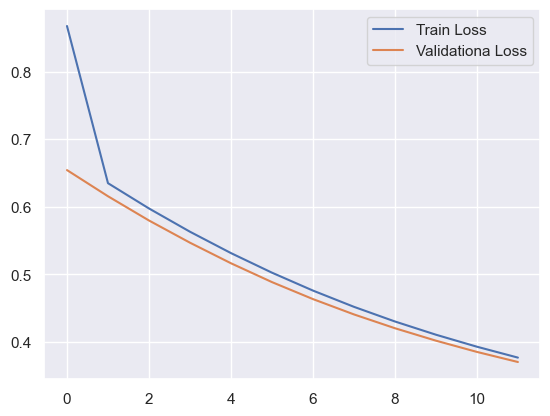

In [82]:
plot_model(siamese_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#To Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validationa Loss')
plt.legend()
plt.show()

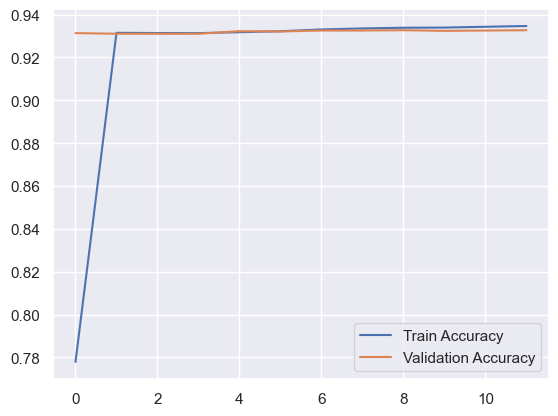

In [83]:
#To Plot Accuracy
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.show()

# To Evaluate Model on Test Data 

In [84]:
siamese_model.evaluate(generate_batches(test_df, BATCH_SIZE),steps=len(test_df) // BATCH_SIZE)

BATCH_SIZE = len(test_df)

num_batched_instances = len(test_df) - (len(test_df) % BATCH_SIZE)

pred_y = siamese_model.predict(generate_batches(test_df, BATCH_SIZE),steps=len(test_df) // BATCH_SIZE,verbose=1)

1/1 [==============================] - 6s 6s/step


In [85]:
print('AUC:', roc_auc_score(test_df.is_similar[:num_batched_instances], pred_y > .5, average='weighted'))
print('Recall:', recall_score(test_df.is_similar[:num_batched_instances], pred_y > .5, average='weighted'))
print('Precision:', precision_score(test_df.is_similar[:num_batched_instances], pred_y > .5, average='weighted'))
print('F1:', f1_score(test_df.is_similar[:num_batched_instances], pred_y > .5, average='weighted'))      

AUC: 0.5386815373842242
Recall: 0.9312839059674503
Precision: 0.9215984064360603
F1: 0.9043899508397479


In [86]:
#Classification Report
print(classification_report(test_df.is_similar[:num_batched_instances], pred_y > .5,))

print('\nAUC:', roc_auc_score(test_df.is_similar[:num_batched_instances], pred_y > .5))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      8203
           1       0.78      0.08      0.14       645

    accuracy                           0.93      8848
   macro avg       0.86      0.54      0.55      8848
weighted avg       0.92      0.93      0.90      8848


AUC: 0.5386815373842242


In [87]:
value_names = ['TPR', 'FPR', 'Threshold']

roc = dict(zip(value_names, roc_curve(test_df.is_similar[:num_batched_instances],pred_y)))

pd.DataFrame(roc)

,TPR,FPR,Threshold
0,0.000000,0.000000,1.999987
1,0.000000,0.001550,0.999987
2,0.000000,0.013953,0.988356
3,0.000122,0.013953,0.985442
4,0.000122,0.027907,0.879764
...,...,...,...
263,0.122394,0.325581,0.260325
264,0.122638,0.325581,0.260324
265,0.122638,0.327132,0.260324
266,0.122882,0.327132,0.260324


# To Evaluate Textually Similar Data

In [88]:
sim_df_original = pd.read_csv('../../PreProcessedData/Eclipse/Eclipse_textually_similar_pair.csv')

print('Dimensions of Dataset: ', sim_df_original.shape)

Dimensions of Dataset:  (446, 9)


In [89]:
#Preprocessing Dataset
sim_df = pd.DataFrame()

sim_df['Unnamed: 0'] = sim_df_original['Unnamed: 0']
sim_df['description1'] = sim_df_original['Description1']
sim_df['description2'] = sim_df_original['Description2']
sim_df['is_similar'] = sim_df_original['is_similar']

sim_df['description1'] = sim_df['description1'].str.replace('[','').str.replace(']','')
sim_df['description2'] = sim_df['description2'].str.replace('[','').str.replace(']','')

sim_df['description1'] = sim_df['description1'].str.replace("'", "")
sim_df['description2'] = sim_df['description2'].str.replace("'", "")

#To show Data
sim_df.head()

,Unnamed: 0,description1,description2,is_similar
0,0,since having a build xml file in a pl...,created attachment screen grab showing error...,1
1,1,created attachment source code that causes t...,it looks like eclipse has trouble with m...,1
2,2,created attachment osgi capture since a...,created attachment orion log this error o...,1
3,3,created attachment log of eclipse installer ...,created attachment installer log what i did...,1
4,6,codefragments internal platform java ...,jdk version java version java se ru...,1


In [90]:
sim_df_new = sim_df[['description1', 'description2', 'is_similar']]
sim_df_new['description2'] = sim_df_new.description2.shift(1)
sim_df_new['is_similar'] = 0
sim_df_new.dropna(inplace = True)
sim_df = pd.concat([sim_df[['description1', 'description2', 'is_similar']],sim_df_new])

In [91]:
BATCH_SIZE = len(sim_df)

siamese_model.evaluate(generate_batches(sim_df, BATCH_SIZE),steps=len(sim_df) // BATCH_SIZE)

num_batched_instances = len(sim_df) - (len(sim_df) % BATCH_SIZE)

pred_y_sim = siamese_model.predict(generate_batches(sim_df, BATCH_SIZE),steps=len(sim_df) // BATCH_SIZE,verbose=1)

1/1 [==============================] - 1s 524ms/step


In [92]:
print('AUC:', roc_auc_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5, average='weighted'))
print('Recall:', recall_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5, average='weighted'))
print('Precision:', precision_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5, average='weighted'))
print('F1:', f1_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5, average='weighted'))  

AUC: 0.5580969416032651
Recall: 0.5578002244668911
Precision: 0.5806756938426052
F1: 0.5245988431052475


In [93]:
#Classification Report
print(classification_report(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5,))

print('\nAUC:', roc_auc_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5))

              precision    recall  f1-score   support

           0       0.54      0.82      0.65       445
           1       0.62      0.29      0.40       446

    accuracy                           0.56       891
   macro avg       0.58      0.56      0.52       891
weighted avg       0.58      0.56      0.52       891


AUC: 0.5580969416032651


# To Evaluate Textually Dissimilar Data

In [94]:
dissim_df_original = pd.read_csv('../../PreProcessedData/Eclipse/Eclipse_textually_dissimilar_pair.csv')

print('Dimensions of Dataset: ', dissim_df_original.shape)

Dimensions of Dataset:  (544, 9)


In [95]:
#Preprocessing Dataset
dissim_df = pd.DataFrame()

dissim_df['Unnamed: 0'] = dissim_df_original['Unnamed: 0']
dissim_df['description1'] = dissim_df_original['Description1']
dissim_df['description2'] = dissim_df_original['Description2']
dissim_df['is_similar'] = dissim_df_original['is_similar']

#df['my_column'] = df['my_column'].str.replace('[','').str.replace(']','')
dissim_df['description1'] = dissim_df['description1'].str.replace('[','').str.replace(']','')
dissim_df['description2'] = dissim_df['description2'].str.replace('[','').str.replace(']','')

#df['my_column'] = df['my_column'].str.replace("'", "")
dissim_df['description1'] = dissim_df['description1'].str.replace("'", "")
dissim_df['description2'] = dissim_df['description2'].str.replace("'", "")

#To show Data
dissim_df.head()

,Unnamed: 0,description1,description2,is_similar
0,0,affected versions of this package are vulnerab...,update the dependency and remove work around i...,1
1,1,we ll use this bug to track the release we re...,we ll use this bug to track the release we re...,1
2,2,we ll use this bug to track the release we re...,we ll use this bug to track the release we re...,1
3,3,we ll use this bug to track the release we re...,we ll use this bug to track the release we re...,1
4,4,we ll use this bug to track the release we re...,we ll use this bug to track the release we re...,1


In [96]:
#Adding Data to the Dataframe
dissim_df_new = dissim_df[['description1', 'description2', 'is_similar']]
dissim_df_new['description2'] = dissim_df_new.description2.shift(1)
dissim_df_new['is_similar'] = 0
dissim_df_new.dropna(inplace = True)
dissim_df = pd.concat([sim_df[['description1', 'description2', 'is_similar']],dissim_df_new])

In [97]:
BATCH_SIZE = len(dissim_df)

siamese_model.evaluate(generate_batches(dissim_df, BATCH_SIZE), steps=len(dissim_df) // BATCH_SIZE)

num_batched_instances = len(dissim_df) - (len(dissim_df) % BATCH_SIZE)

pred_y_dis = siamese_model.predict(generate_batches(dissim_df, BATCH_SIZE),steps=len(dissim_df) // BATCH_SIZE,verbose=1)

1/1 [==============================] - 1s 788ms/step


In [98]:
print('AUC:', roc_auc_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5, average='weighted'))
print('Recall:', recall_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5, average='weighted'))
print('Precision:', precision_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5, average='weighted'))
print('F1:', f1_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5, average='weighted'))  

AUC: 0.606881229462065
Recall: 0.7252440725244073
Precision: 0.7056864307787272
F1: 0.6904784741723348


In [99]:
#Classification Report
print(classification_report(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5,))

print('\nAUC:', roc_auc_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       988
           1       0.62      0.29      0.40       446

    accuracy                           0.73      1434
   macro avg       0.68      0.61      0.61      1434
weighted avg       0.71      0.73      0.69      1434


AUC: 0.606881229462065
